# Land Surface Temperature Workflow
The Planetary Variable Land Surface Temperature (LST) offers a high-quality, reliable dataset to better model weather systems and improve decision-making. In this jupyter notebook, learn how to use the Planet Subscriptions APIs to request Land Surface Temperature data, walk through a typical workflow, and discover additional resources. 

For more information on working with Planetary Variables in the Subscriptions API and the Land Surface Temperature products, see:
- [Subscribing to Planetary Variables](https://developers.planet.com/docs/subscriptions/pvs-subs/)
- [LST Developer Documentation](https://developers.planet.com/docs/planetary-variables/land-surface-temperature/)

## Before you start
We will need:
1. a Planet API key. See: [Find Your Api Key](https://developers.planet.com/quickstart/apis/#find-your-api-key)
2. to install the following packages in a Python 3.8+ virtual environment:
   1. [Planet SDK for Python](https://planet-sdk-for-python-v2.readthedocs.io/en/latest/get-started/quick-start-guide/#step-1-install-python-37-and-a-virtual-environment)
   2. [rioxarray](https://corteva.github.io/rioxarray/html/installation.html)
   3. [matplotlib](https://matplotlib.org/)
3. to have access to the `LST-AMSR2_V1.0_100` product - your area of access will define which geometry to use for this example walkthrough.
4. (optional) to have a configured credentials for a cloud storage provider (Google Cloud Platform, Amazon Web Services, Microsoft Azure, or Oracle Collaboration Suite).

Below you will find a workflow to subscribe and retrieve Land Surface Temperature data at 100m resolution. You will also find an example on how to plot timeseries, daily and monthly maps.
For the raster/geotiff section, we are using Google Cloud Platform (GCP). You can adjust the code to use your chosen cloud storage provider as required.

The notebook is written for Python 3.8 or greater and is based on the Planet Software Development Kit ([Planet SDK documentation](https://planet-sdk-for-python-v2.readthedocs.io)).

In [28]:
import base64
import datetime as dt
from getpass import getpass
from io import StringIO
import json

import matplotlib.pyplot as plt
import pandas as pd
import rasterio
import rioxarray as rx
import xarray as xr

from planet import Auth
from planet import Session
from planet.clients.subscriptions import SubscriptionsClient
from planet.subscription_request import planetary_variable_source, build_request

## Credentials
The first step is to [Authenticate with Planet services](https://planet-sdk-for-python-v2.readthedocs.io/en/latest/python/sdk-guide/#authenticate-with-planet-services). When running the following code you will be prompted to enter your [Planet API Key](https://developers.planet.com/quickstart/apis/#find-your-api-key), which will be stored securely for making the subsequent calls to the Subscriptions API.

In [8]:
api_key = getpass('Enter your API key:')
auth = Auth.from_key(api_key)

## Define your AOI
In your [Planet account dashboard](https://www.planet.com/account/#/dashboard), you can check your provisioned data - for this walkthrough, you will need to have access to the LST 100m data product. If the example location (Nebraska, USA) is not within your area of access, you can define a new area of interest (AOI) that you would like to use for testing.

**Tip:** You can use the tool [GeoJSON.io](https://geojson.io/#map=2/0/20) to create an AOI geometry to use as per the example below.

In [17]:
geometry = {"coordinates": [[
    [-101.43539213886689, 40.709547875828804],
    [-101.43539213886689, 40.52787626066092],
    [-101.1076439548855, 40.52787626066092],
    [-101.1076439548855, 40.709547875828804],
   [-101.43539213886689, 40.709547875828804]
   ]],
 "type": "Polygon"}

You can also optionally load a geometry directly from a GeoJSON file, for example:

In [12]:
# Get the geometry from a geojson file
fname="my_geometry.geojson"
with open(fname, "r") as file:
    geojson_data = json.load(file)
geometry = geojson_data["features"][0]

## Define your subscription
This first example creates a subscription for 4 years of 100m resolution LST data over the agricultural area of Imperial, Nebraska.

Subscriptions can be created with or without a delivery parameter, which specifies a storage location to deliver raster data. For this first analysis we do not require raster assets, so the delivery parameter has been omitted to create a metadata-only subscription.

In [13]:
subscription_name = "LST_100m_Imperial-Nebraska"

pv_source = planetary_variable_source(var_type="land_surface_temperature",
                                      var_id="LST-AMSR2_V1.0_100",
                                      geometry=geometry,
                                      start_time=dt.datetime(2020, 1, 1),
                                      end_time=dt.datetime(2024, 1, 1))

request = build_request(subscription_name, source=pv_source, delivery={},)

## Create the subscription
Using the [create_subscription](https://planet-sdk-for-python-v2.readthedocs.io/en/latest/python/sdk-reference/#planet.clients.subscriptions.SubscriptionsClient.create_subscription) method, we POST the request defined above to `https://api.planet.com/subscriptions/v1`

In [14]:
# Create the subscription using the function create_subscription
async with Session(auth=auth) as sess:
    cl = SubscriptionsClient(sess)
    subscription_desc = await cl.create_subscription(request)
print(f"{subscription_desc['id']} named {subscription_desc['name']} created")

c82bc224-edaa-4bb9-aee1-005677d18959 named LST_100m_Imperial-Nebraska created


## Monitor the subscription
We now monitor the progress of the subscription with the [get_subscription](https://planet-sdk-for-python-v2.readthedocs.io/en/latest/python/sdk-reference/#planet.clients.subscriptions.SubscriptionsClient.get_subscription) method (subscription status is explained in further detail [here](https://developers.planet.com/docs/subscriptions/#subscription-status))

In [60]:
# get the subscription using the function create_subscription
async with Session(auth=auth) as sess:
    cl = SubscriptionsClient(sess)
    subscription_desc = await cl.get_subscription(subscription_id=subscription_desc['id'])
print(f"{subscription_desc['id']} named {subscription_desc['name']} is {subscription_desc['status']}")

c82bc224-edaa-4bb9-aee1-005677d18959 named LST_100m_Imperial-Nebraska is running


## Retrieve the data
We can start retrieving the subscription data even if the status is 'running'. The `metadata-only` (timeseries) results generated for this subscription is retrieved directly in CSV format with `get_results_csv`. We can use the Pandas library to read this into a DataFrame to perform further analysis and to create a nice time series visualization.

In [61]:
async with Session(auth=auth) as sess:
    cl = SubscriptionsClient(sess)
    results_desc = cl.get_results_csv(subscription_id=subscription_desc['id'])
    results_desc_list = [i async for i in results_desc]

df = pd.read_csv(StringIO("\n".join(results_desc_list)), parse_dates=["item_datetime", "local_solar_time"], index_col="local_solar_time",)
df

,id,item_datetime,status,created,updated,errors,item_id,lst.band-1.mean,lst.band-1.valid_percent,source_id
local_solar_time,,,,,,,,,,
2020-01-01 01:30:00,f237e794-28fa-4d6a-9f66-21326a02b3b4,2020-01-01 08:30:00+00:00,SUCCESS,2024-05-29T16:50:48.837316Z,2024-05-29T16:50:48.837316Z,{},LST-AMSR2_V1.0_100_2020-01-01T0130,266.34,93,LST-AMSR2_V1.0_100
2020-01-01 13:30:00,08e69476-b7c2-4c7a-ae61-6161b75ac164,2020-01-01 20:30:00+00:00,SUCCESS,2024-05-29T18:32:07.38215Z,2024-05-29T18:32:07.38215Z,{},LST-AMSR2_V1.0_100_2020-01-01T1330,280.50,100,LST-AMSR2_V1.0_100
2020-01-02 01:30:00,b5912dbe-21c8-4309-ab87-192dcda4076e,2020-01-02 08:30:00+00:00,SUCCESS,2024-05-29T16:50:51.639637Z,2024-05-29T16:50:51.639637Z,{},LST-AMSR2_V1.0_100_2020-01-02T0130,269.30,100,LST-AMSR2_V1.0_100
2020-01-02 13:30:00,18dbc5e2-a097-4984-81bb-4c07368b118e,2020-01-02 20:30:00+00:00,SUCCESS,2024-05-29T18:32:09.373352Z,2024-05-29T18:32:09.373352Z,{},LST-AMSR2_V1.0_100_2020-01-02T1330,279.58,100,LST-AMSR2_V1.0_100
2020-01-03 01:30:00,a0c1980c-235c-4d5a-881c-371d92d32b25,2020-01-03 08:30:00+00:00,SUCCESS,2024-05-29T16:50:53.837473Z,2024-05-29T16:50:53.837473Z,{},LST-AMSR2_V1.0_100_2020-01-03T0130,270.79,100,LST-AMSR2_V1.0_100
...,...,...,...,...,...,...,...,...,...,...
2023-12-29 13:30:00,842ddf7c-ed10-4461-abcb-20a0c4b061fe,2023-12-29 20:30:00+00:00,SUCCESS,2024-05-29T20:15:41.37625Z,2024-05-29T20:15:41.37625Z,{},LST-AMSR2_V1.0_100_2023-12-29T1330,280.77,100,LST-AMSR2_V1.0_100
2023-12-30 01:30:00,df2ce2d4-9ff1-4cf0-b378-03e121a7a6a7,2023-12-30 08:30:00+00:00,SUCCESS,2024-05-29T18:32:02.973029Z,2024-05-29T18:32:02.973029Z,{},LST-AMSR2_V1.0_100_2023-12-30T0130,NaN,0,LST-AMSR2_V1.0_100
2023-12-30 13:30:00,1eb78355-6db1-460b-9bd7-afb850899406,2023-12-30 20:30:00+00:00,SUCCESS,2024-05-29T20:15:43.304833Z,2024-05-29T20:15:43.304833Z,{},LST-AMSR2_V1.0_100_2023-12-30T1330,281.02,100,LST-AMSR2_V1.0_100


## Temporal Analysis

Now, we are ready to analyze the average temperature of the agricultural region over time. Two time series plots are created: one for nighttime observations (captured at 01:30 solar time) and one for daytime observations (captured at 13:30 solar time). A rolling backward windows average is also plotted to show the 10 days trend. When the subscription is completed, this will be a full record of the temperature data over the four years requested.

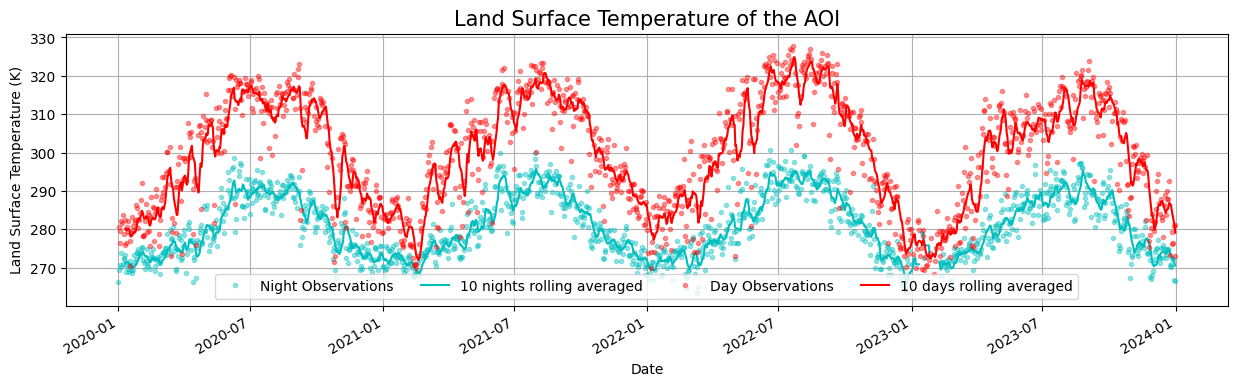

In [62]:
backward_average_window_size=10

# Plot the Land Surface Temperature time-series for nighttime observations
df.between_time("1:15", "1:45")["lst.band-1.mean"].plot(
    grid=True, style="c.", alpha=0.4, label="Night Observations", figsize=(15, 4)
)
df["average"] = df.between_time("1:15", "1:45")["lst.band-1.mean"].rolling(
    window=pd.Timedelta(days=backward_average_window_size), min_periods=1, center=False, closed=None
    ).mean()[backward_average_window_size - 1:].plot(
    grid=True, style="c-", label=f"{backward_average_window_size} nights rolling averaged", figsize=(15, 4)
)

# Plot the Land Surface Temperature time-series for daytime observations
df.between_time("13:15", "13:45")["lst.band-1.mean"].plot(
    grid=True, style="r.", alpha=0.4, label="Day Observations", figsize=(15, 4)
)
df["average"] = df.between_time("13:15", "13:45")["lst.band-1.mean"].rolling(
    window=pd.Timedelta(days=backward_average_window_size), min_periods=1, center=False, closed=None
    ).mean()[backward_average_window_size - 1:].plot(
    grid=True, style="r-", label=f"{backward_average_window_size} days rolling averaged", figsize=(15, 4)
)

# Extra information for the visualization
plt.ylabel("Land Surface Temperature (K)", size = 10)
plt.xlabel("Date", size = 10)
plt.title("Land Surface Temperature of the AOI", size = 15)
plt.legend(ncols=4)

## Subscription with Raster delivery
In addition to providing metadata over an Area of Interest, you can also configure the delivery of raster results directly to a cloud storage location. We will use the same method as above to generate the request but now provide an additional `delivery` configuration. In this example, we will now focus on the month of July 2022.

See the [supported delivery options](https://developers.planet.com/docs/subscriptions/delivery/#supported-delivery-options) or the [API reference](https://developers.planet.com/docs/subscriptions/reference/#tag/subscriptions/operation/createSubscription) to review the configuration options for different cloud storage providers. This example uses Google Cloud Storage.

To deliver results directly to a Google Cloud Storage bucket, specify the delivery location and provide your authentication credentials. These credentials will require read/write permissions on the specified bucket. See the [Google Cloud documentation](https://cloud.google.com/iam/docs/keys-create-delete#iam-service-account-keys-create-console) on how to create a service account key with the appropriate permissions. When using AWS, Azure or OCS, use the corresponding credentials for those platforms.

In [49]:
# Only for Cloud Storage Delivery
bucket_name="<YOUR BUCKET NAME>"
GOOGLE_APPLICATION_CREDENTIALS="~/.config/gcloud/application_default_credentials.json" # Adjust to your json file location for a GCP service account key with Cloud Storage permission

# Credentials are expected in base64 format -the following reads the json key as bytes,
# applies the base64 encoding and decodes back to a python str
with open(GOOGLE_APPLICATION_CREDENTIALS, "rb") as f:
    gcs_credentials_base64 = base64.b64encode(f.read()).decode()

# Your GCP bucket and credentials to save rasters
delivery_config_gcp = {
    "type": "google_cloud_storage",
    "parameters": {
        "bucket": bucket_name,
        "credentials": gcs_credentials_base64,
    }
}

In [46]:
subscription_name = "LST_100m Imperial Nebraska July 2022"

pv_source = planetary_variable_source(var_type="land_surface_temperature",
                                      var_id="LST-AMSR2_V1.0_100",
                                      geometry=geometry,
                                      start_time=dt.datetime(2022, 7, 1),
                                      end_time=dt.datetime(2022, 8, 1))

request = build_request(subscription_name, source=pv_source, delivery=delivery_config_gcp,)

In [54]:
# Create the subscription using the function create_subscription
async with Session(auth=auth) as sess:
    cl = SubscriptionsClient(sess)
    subscription_details = await cl.create_subscription(request)
print(f"{subscription_details['id']} named {subscription_details['name']} created")

942d85b3-4ab2-4774-afa8-cadc804c39f0 named LST_100m Imperial Nebraska July 2022 created


## Spatial Analysis
The geotiff (raster) files will now be delivered to our Cloud Storage bucket.

The rioxarray extension to [rasterio](https://rasterio.readthedocs.io/en/latest/installation.html) can be used to open and map the delivered GeoTIFF files directly from their cloud storage location.

Rasterio uses GDAL under the hood, which supports accessing [network based file systems](https://gdal.org/user/virtual_file_systems.html#network-based-file-systems) across different cloud providers. For more information, see:

- [Amazon Web Service](https://gdal.org/user/virtual_file_systems.html#vsis3-aws-s3-files)
- [Google Cloud](https://gdal.org/user/virtual_file_systems.html#vsigs-google-cloud-storage-files)
- [Microsoft Azure](https://gdal.org/user/virtual_file_systems.html#vsiaz-streaming-microsoft-azure-blob-files-streaming)

In the following example, the data is read directly from our previously configured Google Cloud Storage bucket to visualize the Land Surface Temperature 100m resolution map over our AOIs on the 18th of July, 2022.

<xarray.Dataset>
Dimensions:      (x: 369, y: 206)
Coordinates:
  * x            (x) float64 -101.4 -101.4 -101.4 ... -101.1 -101.1 -101.1
  * y            (y) float64 40.71 40.71 40.71 40.71 ... 40.53 40.53 40.53 40.53
    spatial_ref  int64 0
Data variables:
    band_1       (y, x) float32 ...
    band_2       (y, x) float32 ...
Attributes:
    AREA_OR_POINT:  Area


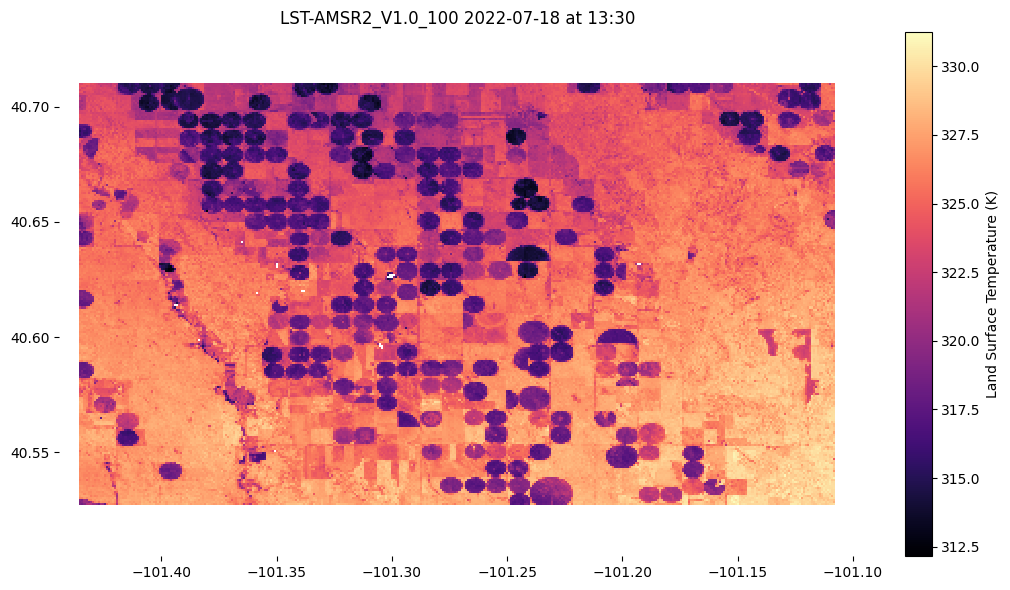

In [69]:
# Set the filepath to the 18 July 2022 GeoTIFF asset
date="2022-07-18"

subscription_id = subscription_details["id"]
lst_file_location = f"gs://{bucket_name}/{subscription_id}/{date.replace('-','/')}/LST-AMSR2_V1.0_100-{date.replace('-','')}T1330_lst.tiff"

# Use the Google Application credentials to allow access to the storage location
with rasterio.env.Env(GOOGLE_APPLICATION_CREDENTIALS=GOOGLE_APPLICATION_CREDENTIALS):
    lst_data = rx.open_rasterio(lst_file_location, mask_and_scale=True, band_as_variable=True)
    print(lst_data)

    lst_data = lst_data.rename_vars({
        "band_1":"Land Surface Temperature (K)",
        "band_2":"Masked LST values (K)",
    })

    aspect = lst_data["x"].size / lst_data["y"].size

    fig, ax = plt.subplots(figsize=(6*aspect, 6))
    lst_data["Land Surface Temperature (K)"].plot(ax=ax, cmap="magma", )

    ax.set_title(f"LST-AMSR2_V1.0_100 {date} at 13:30")
    ax.axis("equal")
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_frame_on(False)
    plt.tight_layout()

In the second spatial analysis, we open all the geotiffs between two dates into a xarray.DataSet and we compute the monthly average of temperature.

In [70]:
date_range = pd.date_range(start="2022-07-01", end="2022-07-31").strftime("%Y-%m-%d")
subscription_id = subscription_details["id"]

july_data = []
with rasterio.env.Env(GOOGLE_APPLICATION_CREDENTIALS=GOOGLE_APPLICATION_CREDENTIALS):
  for date in date_range:
    lst_file_location = f"gs://{bucket_name}/{subscription_id}/{date.replace('-','/')}/LST-AMSR2_V1.0_100-{date.replace('-','')}T1330_lst.tiff"
    july_data.append(rx.open_rasterio(lst_file_location, mask_and_scale=True, band_as_variable=True).assign_coords({"date": date}))

timeseries = xr.concat(july_data, dim="date")
timeseries['date'] = pd.DatetimeIndex(timeseries['date'].values)
timeseries = timeseries.rename_vars({
    "band_1":"Land Surface Temperature (K)",
    "band_2": "Masked LST values (K)",
})

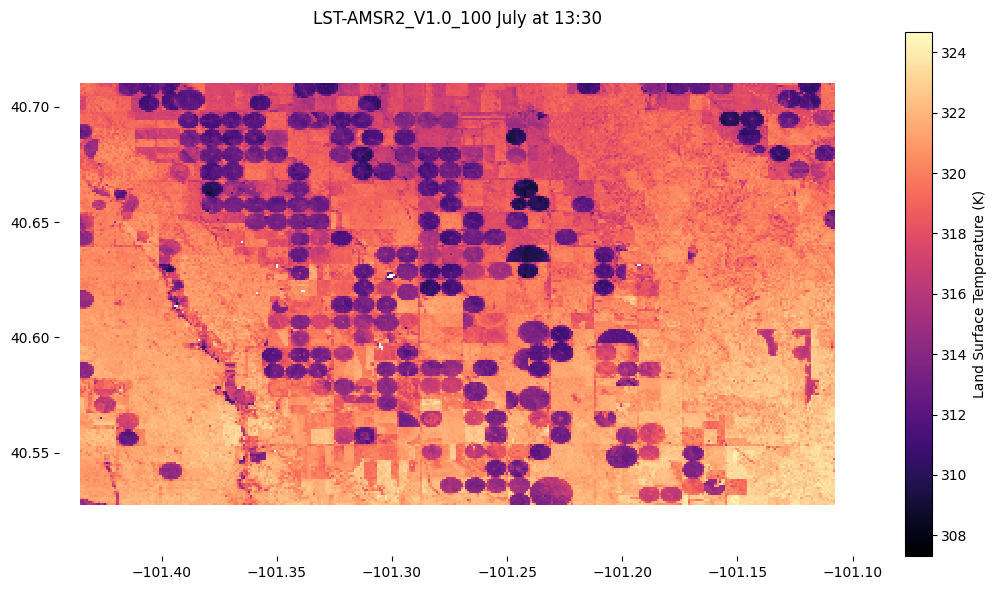

In [56]:
average = timeseries.resample(date="M").mean()

aspect = average["x"].size / average["y"].size

fig, ax = plt.subplots(figsize=(6*aspect, 6))
average["Land Surface Temperature (K)"].plot(ax=ax, cmap="magma", )

ax.set_title("LST-AMSR2_V1.0_100 July at 13:30")
ax.axis('equal')
ax.set_frame_on(False)
ax.set_xlabel('')
ax.set_ylabel('')
plt.tight_layout()

Finally, we save the LST averaged map as a new locally stored geotiff.

In [55]:
average["Land Surface Temperature (K)"].rio.to_raster("LST-AMSR2_V1.0_100_July_1330.tiff")